In [ ]:
!pip install pystan
!pip install fbprophet
!pip install pmdarima

In [ ]:
#Importing libraries
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
%matplotlib inline
import matplotlib as mpl
from fbprophet import Prophet
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_468.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [ ]:
data.rename( columns={'Flow':'DMA_468','Date-time':'Date_time'}, inplace=True )
data_DMA468 = data[['Date_time','DMA_468']]

In [ ]:
figure = px.line(data_DMA468,x="Date_time",y="DMA_468",title="DMA_468 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [ ]:
data_DMA468_indexed = data_DMA468.set_index('Date_time')
hourly_data = data_DMA468_indexed.resample('h').sum()

#Stationarity check

In [ ]:
#Statistical information
hourly_data.describe()

,DMA_468
count,8760.000000
mean,3.313481
std,1.836744
min,0.000000
25%,1.477750
50%,3.589000
75%,4.700000
max,19.456000


<Figure size 1584x720 with 0 Axes>

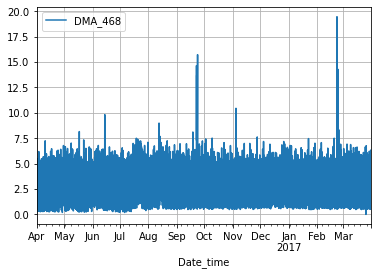

<Figure size 1584x720 with 0 Axes>

In [ ]:
# Looking at plots
DMA468_df_indexed = hourly_data[['DMA_468']]
DMA468_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [ ]:
# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(hourly_data)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.137910
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -11. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.000058 < 0.05 ; Data is stationary

In [ ]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(hourly_data)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.21960694171448059,
 0.1,
 37,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation : 1.The ADF statistic value of 0.2. The positive value is statistic, and hence we have a stationary dataset.

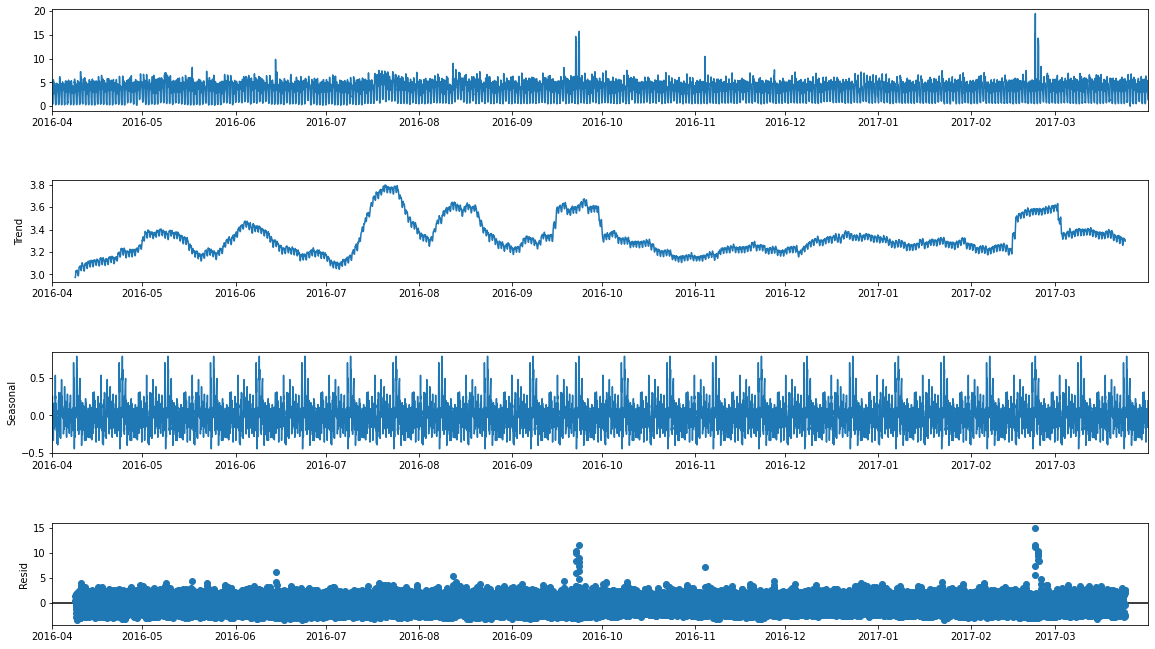

In [ ]:
res=sm.tsa.seasonal_decompose(hourly_data,period=365)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f45ec88c850>],
      dtype=object)

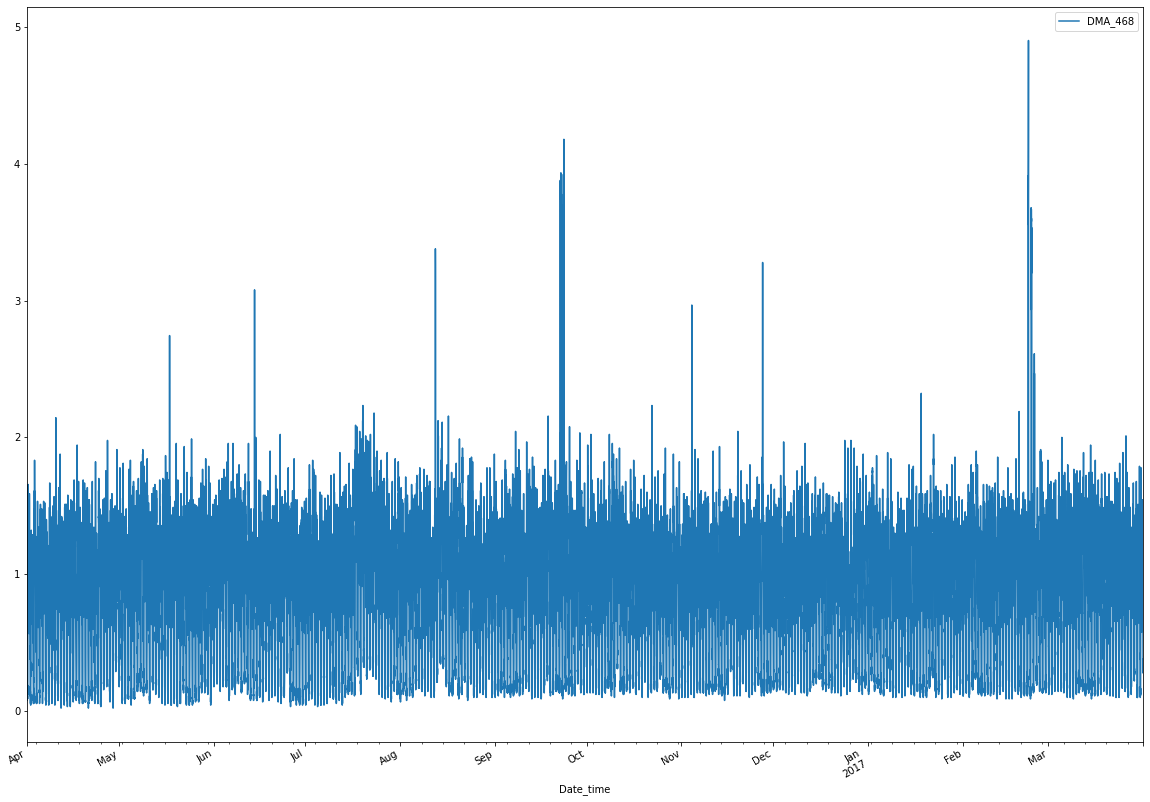

In [ ]:
mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False
data_DMA468_indexed[['DMA_468']].plot(subplots=True)

In [ ]:
#general Information
data_DMA468_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2016-04-01 00:00:00 to 2017-03-31 23:45:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DMA_468  35034 non-null  float64
dtypes: float64(1)
memory usage: 547.5 KB


In [ ]:
#Statistical information
data_DMA468_indexed.describe()

,DMA_468
count,35034.000000
mean,0.828512
std,0.475799
min,0.022000
25%,0.356000
50%,0.889000
75%,1.178000
max,4.900000


In [ ]:
# Making hourly data 
hourly_data = data_DMA468_indexed.resample('h').sum()

#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_468':'y'})
hourly_data_index.shape

(8760, 2)

In [ ]:
#Train and test split
split = 1059
train = hourly_data_index[:-1059]
test = hourly_data_index[-1059:]

In [ ]:
#Instatntiate model
model = Prophet()
#Train
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Forecast / Predict

future_prediction = model.make_future_dataframe(periods = test.shape[0], freq = '1H')  
forecast_prediction = model.predict(test)
forecast_prediction[['ds', 'yhat']]

,ds,yhat
0,2017-02-15 21:00:00,2.978581
1,2017-02-15 22:00:00,2.043671
2,2017-02-15 23:00:00,1.382935
3,2017-02-16 00:00:00,0.978184
4,2017-02-16 01:00:00,0.681325
...,...,...
1054,2017-03-31 19:00:00,4.686014
1055,2017-03-31 20:00:00,3.960208
1056,2017-03-31 21:00:00,2.967200
1057,2017-03-31 22:00:00,2.034152


In [ ]:
# Making final df of original and predicted value
fp = forecast_prediction[['ds', 'yhat']]
fd=pd.merge(test, fp, on="ds")

In [ ]:
# Calculate rmse of original and predicted value
rmse = np.sqrt(mean_squared_error(fd.y,fd.yhat))
rmse = round(rmse, 3)
print (" The root mean square vaue on testset: ",rmse)

 The root mean square vaue on testset:  1.2


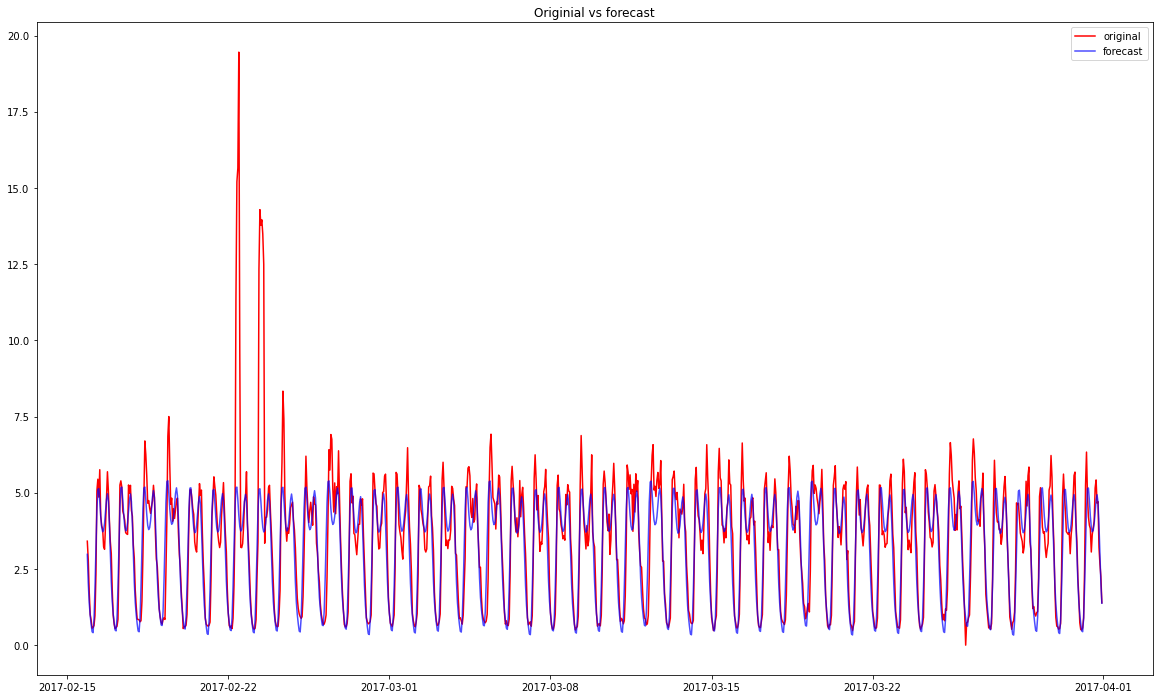

In [ ]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(fd.ds, fd.y, color='red', label='original')
plt.plot(fd.ds, fd.yhat, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()